In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

In [2]:
current_dir = Path(os.getcwd())
project_dir = current_dir.parent.parent.absolute()

## Key notes
--------------------------------------------
- In last notebook we deblur **two-proton** source function from noisy correlation using RL algorithm with maximum-entropy method. 
- In this notebook we attempt to do the same for **d-$\alpha$** correlation function.

### 0. preparation
-------------------------
All essential steps except regularization is the same as the last notebook.

In [3]:
def gaus_source(r, R, lambda_=1.):
    return lambda_ / (2 * np.sqrt(np.pi) * R)**3 * np.exp(-r**2 / 4 / R**2)

R_true = 3.0
lambda_true = 0.8

In [4]:
# kernel fine-binned in r
q_fine, r_fine, kernel_fine = np.load(str(project_dir / 'database/kernel/d4He/4mev.npz')).values()

(0.0, 20.0)

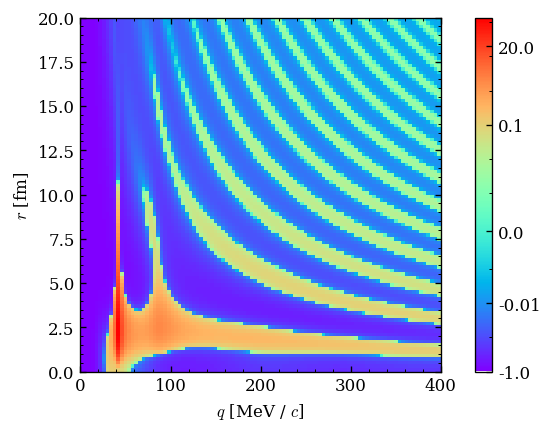

In [5]:
fig, ax = plt.subplots(figsize=(4.5,3.5),constrained_layout=True, )
h = ax.pcolormesh(
    q_fine, r_fine, kernel_fine.T,
    cmap='rainbow', shading='auto',
    rasterized=True,
    norm=mpl.colors.SymLogNorm(linthresh=1e-3, linscale=1, vmin=kernel_fine.min(), vmax=kernel_fine.max())
)

colorbar = fig.colorbar(h, ax=ax)
colorbar.set_ticks([-1.00, -0.01, 0.00, 0.10, 20.00])
colorbar.set_ticklabels([-1.00, -0.01, 0.00, 0.10, 20.00])

ax.set_xlabel(r'$q$ [MeV / $c$]')
ax.set_ylabel(r'$r$ [fm]')

ax.set_xlim(0, 400)
ax.set_ylim(0, 20)

In [6]:
source_truth = gaus_source(r_fine, R_true, lambda_true)
K_fine = 4 * np.pi * (kernel_fine+1/lambda_true) * r_fine**2 * (r_fine[1]-r_fine[0])
correlation_truth = np.dot(K_fine, source_truth)

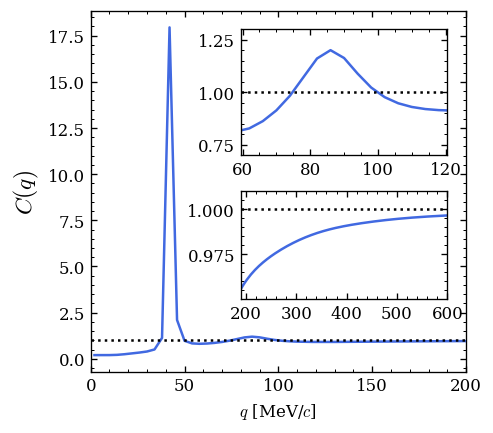

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(q_fine, correlation_truth, color='royalblue')

axins = ax.inset_axes(
    [0.4, 0.6, 0.55, 0.35],
)
axins.plot(q_fine, correlation_truth, color='royalblue')
axins.axhline(1, color='black', ls=':')
axins.set_xlim(59.5, 120.5)
axins.set_ylim(0.7, 1.3)


axins = ax.inset_axes(
    [0.4, 0.2, 0.55, 0.3],
)
axins.plot(q_fine, correlation_truth, color='royalblue')
axins.axhline(1, color='black', ls=':')
axins.set_xlim(190, 510)
axins.set_ylim(0.95, 1.01)
axins.set_xticks([200, 300, 400, 500, 600])
axins.set_yticks([0.975, 1.0])

ax.axhline(1, color='black', ls=':')
ax.set_xlim(0, 200)
ax.set_xlabel(r'$q$ [MeV/$c$]')
ax.set_ylabel(r'$C(q)$', fontsize=14)

plt.show()


### 1. construct coarse-binned kernel
-----------------------------------------

In [8]:
q, r, dr, kernel = np.load(str(project_dir / 'database/kernel/d4He/custom.npz')).values()

In [9]:
K = 4 * np.pi * (kernel+1/lambda_true) * r**2 * dr
source_coarse = gaus_source(r, R_true, lambda_true)
correlation_coarse = np.dot(K, source_coarse)

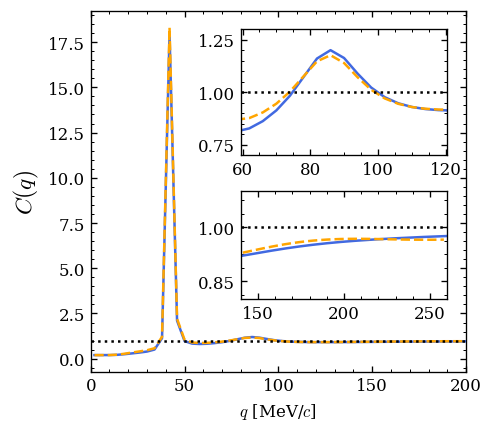

In [10]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(q_fine, correlation_truth, color='royalblue')
ax.plot(q, correlation_coarse, color='orange', ls='--')

axins = ax.inset_axes(
    [0.4, 0.6, 0.55, 0.35],
)
axins.plot(q_fine, correlation_truth, color='royalblue')
axins.plot(q, correlation_coarse, color='orange', ls='--')
axins.axhline(1, color='black', ls=':')
axins.set_xlim(59.5, 120.5)
axins.set_ylim(0.7, 1.3)


axins = ax.inset_axes(
    [0.4, 0.2, 0.55, 0.3],
)
axins.plot(q_fine, correlation_truth, color='royalblue')
axins.plot(q, correlation_coarse, color='orange', ls='--')
axins.axhline(1, color='black', ls=':')
axins.set_xlim(140, 260)
axins.set_ylim(0.8, 1.1)
axins.set_xticks([150,200,250])
axins.set_yticks([0.85, 1.0])

ax.axhline(1, color='black', ls=':')
ax.set_xlim(0, 200)
ax.set_xlabel(r'$q$ [MeV/$c$]')
ax.set_ylabel(r'$C(q)$', fontsize=14)

plt.show()


## Generate synthetic data
----------------------------------------
As before, we construct the correlation function with the same parameter and perturb the resulting correlation function according to experimental errorbars, i.e.
$$ C \sim \mathcal{N}(C, \delta C)$$
- In particular, the first bin of data are missing. 
- errorbar at $q>400$ MeV$/c$ are exceedingly high so a sharp cut is applied
- correlation calculated from custom kernel starts to deviate from truth at $q > 200$ MeV$/c$.

Therefore, we will only restore the source function from data in the region $q <= 260$ MeV$/c$. Moreover, there is an need to introduce resolution effect to account for the first peak. To achieve this, we convolute the correlation / kernel in the `q`-axis with a gaussian kernel with a given hyper-parameter $\sigma_q$. 

In [11]:
qmax = min(260, q.max())

In [12]:
df_error = pd.read_csv(project_dir / 'database/cf/d4He/error-4mev.csv')
df_error.query('yerr > 0.0', inplace=True)
df_error.query(f'x < {qmax}', inplace=True)
q_indices = np.digitize(df_error.x.values, q, right=True)

In [13]:
def gaussian_filter(x, sigma):
    gaussian = lambda x, mu, sigma: 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-0.5 * (x - mu)**2 / sigma**2)
    kernel = np.array([
        [gaussian(x[i] - x[j], 0., sigma) for j in range(len(x))] for i in range(len(x))
    ])
    return kernel / np.sum(kernel, axis=0)

In [14]:
def gaus_convolve_1d(x, y, sigma):
    kernel = gaussian_filter(x, sigma)
    return np.dot(kernel, y)

In [15]:
sigma_q_truth = 2.2

In [16]:
convolved = gaus_convolve_1d(q[q_indices], correlation_truth[q_indices], sigma_q_truth)

In [17]:
seed = 123
rng = np.random.default_rng(seed)
blurred = rng.normal(convolved, df_error['yerr'].values)

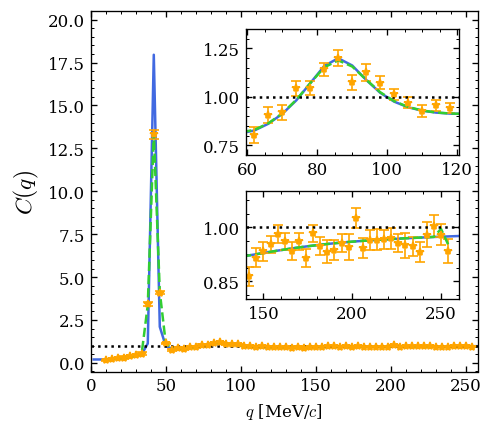

In [18]:
fig, ax = plt.subplots(constrained_layout=True, )
ax.plot(q_fine, correlation_truth, color='royalblue')

ax.errorbar(
    q[q_indices], blurred, df_error['yerr'].values, marker='*', ls='none', color='orange',
    capsize=3, capthick=1, elinewidth=1, markersize=5
)

ax.plot(q[q_indices], convolved, ls='--', color='limegreen')


axins = ax.inset_axes(
    [0.4, 0.6, 0.55, 0.35],
)
axins.plot(q_fine, correlation_truth, color='royalblue')
axins.errorbar(
    q[q_indices], blurred, df_error['yerr'].values, marker='*', ls='none', color='orange',
    capsize=3, capthick=1, elinewidth=1, markersize=5
)
axins.plot(q[q_indices], convolved, ls='--', color='limegreen')

axins.axhline(1, color='black', ls=':')
axins.set_xlim(59.5, 120.5)
axins.set_ylim(0.7, 1.35)


axins = ax.inset_axes(
    [0.4, 0.2, 0.55, 0.3],
)
axins.plot(q_fine, correlation_truth, color='royalblue')
axins.errorbar(
    q[q_indices], blurred, df_error['yerr'].values, marker='*', ls='none', color='orange',
    capsize=3, capthick=1, elinewidth=1, markersize=5
)
axins.plot(q[q_indices], convolved, ls='--', color='limegreen')

axins.axhline(1, color='black', ls=':')
axins.set_xlim(140, 260)
axins.set_ylim(0.8, 1.1)
axins.set_xticks([150,200,250])
axins.set_yticks([0.85, 1.0])



ax.axhline(1, color='black', ls=':')
ax.set_xlim(0, qmax)
ax.set_ylim(-0.5, 20.5)
ax.set_xlabel(r'$q$ [MeV/$c$]')
ax.set_ylabel(r'$C(q)$', fontsize=14)

plt.show()


## Maximum-Entropy regularized RL
----------------------------------------

In [19]:
def richardson_lucy_me(niter, X, y, psf, Pi, alpha=0., accelerated=True, accel_rate=2.0, return_all=False):
    y_norm = np.sum(y)
    psf_norm = np.sum(psf, axis=0)

    psf_ = psf / psf_norm
    img = y / y_norm
    Pi_ = Pi / np.sum(Pi, axis=0)

    deconv = X / np.sum(X)
    conv = np.dot(psf_, deconv) + 1e-12

    X_preds = []
    y_preds = []
    ts = []

    for _ in range(niter):
        deltaH = deconv * (np.einsum('i,ij', img / conv, psf_) - 1)
        # conservation of flux
        assert np.abs(np.sum(deconv) - 1) < 1e-6
        assert np.abs(np.sum(deltaH)) < 1e-6

        deltaS = np.zeros_like(deconv)
        if alpha != 0:
            chi = np.dot(Pi_, deconv)
            Sratio = deconv / chi
            lnSratio = np.log(Sratio)
            S = - np.sum(deconv * lnSratio)
            deltaS = -alpha * deconv * (
                1 + lnSratio + S - np.dot(Pi_.T, Sratio)
            )
            assert np.abs(np.sum(deltaS)) < 1e-6

        delta = deltaH + deltaS

        accel = 1.
        if accelerated:
            # from positivity constraint
            accel_c = np.divide(deconv, np.abs(delta), out=np.zeros_like(deconv), where=delta!=0)
            accel_c = accel_c[delta < 0].min()
            accel = min(accel_c, accel_rate)
            assert accel > 1

        deconv = deconv + accel * delta
        conv = np.dot(psf_, deconv) + 1e-12
        t = np.abs(delta) / (np.abs(deltaH) + np.abs(deltaS))

        X_preds.append(deconv * y_norm / psf_norm)
        y_preds.append(conv * y_norm)
        ts.append(t)

        if alpha > 0. and np.all(t < 1e-3):
            break
    
    if return_all:
        return X_preds, y_preds, ts
    return X_preds[-1], y_preds[-1], ts[-1]

In [20]:
def construct_Pi(r, sigma):
    simple_gaussian = lambda x, mu, s : 1 / np.sqrt(2 * np.pi * s**2) * np.exp(-(x - mu)**2 / 2 / s**2)
    return np.array([
        [simple_gaussian(rj - rk, 0, sigma) for rj in r] for rk in r
    ])

In [21]:
lambda_guess = 0.8 # same as truth
sigma_q_guess = 2.0 # close to truth

# other hyperparameters
alpha = 0.3
sigma_r = 1.5

In [22]:
flat_guess = np.ones_like(r)
flat_guess /= np.sum(flat_guess * 4 * np.pi * r**2 * dr)
flat_guess *= lambda_guess

In [23]:
psf = np.transpose([
    gaus_convolve_1d(q[q_indices], k, sigma_q_guess) for k in K[q_indices, :].T
])

In [24]:
niter = 150000
restored_list, predicted_list, t_list = richardson_lucy_me(
    niter = niter, 
    X = flat_guess,
    y = blurred,
    psf = psf,
    return_all = True,
    accelerated = True, 
    accel_rate = 1.99,
    alpha = alpha,
    Pi = construct_Pi(r, sigma_r)
)

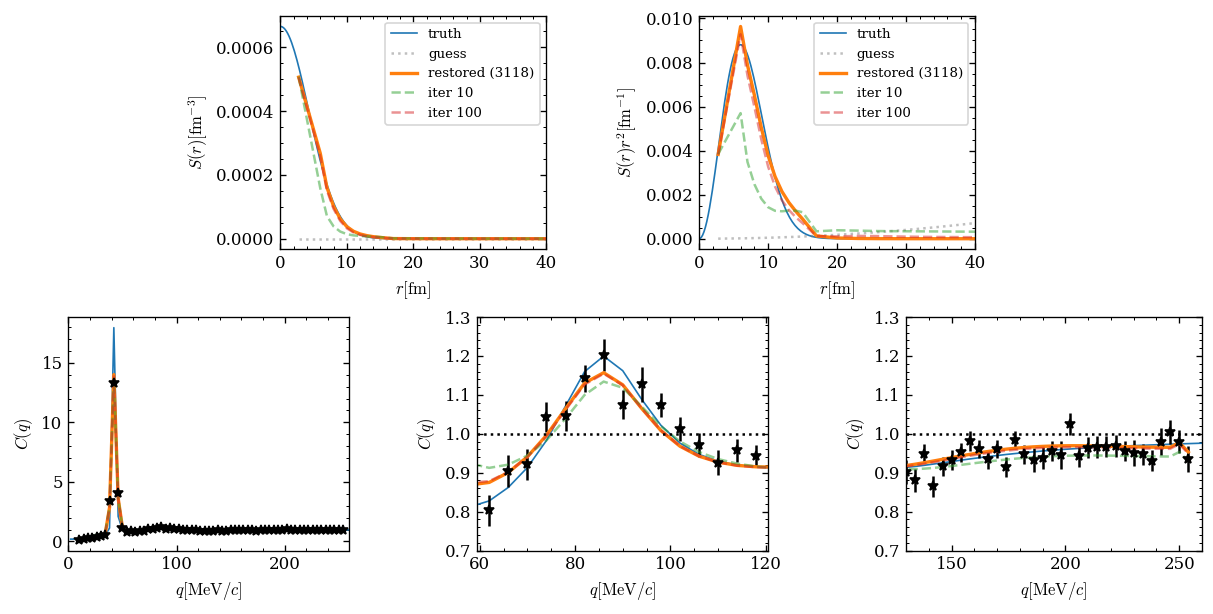

In [25]:
fig, axes = plt.subplot_mosaic(
    [
        ['.', 'a', 'a', 'b', 'b', '.'],
        ['c', 'c', 'd', 'd', 'e', 'e']
    ],
    figsize=(10, 5),
    constrained_layout=True,
    
)

axes['a'].plot(r_fine, source_truth , label='truth', lw=1)
axes['a'].plot(r, flat_guess, label='guess', ls=':', color='gray', alpha=0.5)
axes['a'].plot(r, restored_list[-1], label=f'restored ({len(restored_list):0d})', ls='-', lw=2)

axes['b'].plot(r_fine, source_truth * r_fine**2 , label='truth', lw=1)
axes['b'].plot(r, flat_guess * r**2, label='guess', ls=':', color='gray', alpha=0.5)
axes['b'].plot(r, restored_list[-1] * r**2, label=f'restored ({len(restored_list):0d})', ls='-', lw=2)

for ax_label in ['c', 'd', 'e']:
    axes[ax_label].plot(q_fine, correlation_truth, label='truth', lw=1)
    axes[ax_label].errorbar(
        q[q_indices], blurred, yerr=df_error['yerr'].values, 
        label='blurred', marker='*', color='k', ls='none'
    )
    axes[ax_label].plot(q[q_indices], predicted_list[-1], label=f'predicted ({len(predicted_list):0d})', ls='-', lw=2)

for i, epoch in enumerate([10, 100, 5000, 10000, 100000]):
    if epoch > len(restored_list):
        continue
    axes['a'].plot(r, restored_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)
    axes['b'].plot(r, restored_list[epoch - 1] * r**2, ls='--', label=f'iter {epoch}', alpha=0.5)
    axes['c'].plot(q[q_indices], predicted_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)
    axes['d'].plot(q[q_indices], predicted_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)
    axes['e'].plot(q[q_indices], predicted_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)


axes['a'].set_xlim(0, 40)
axes['a'].set_xlabel(r'$r [\mathrm{fm}]$')
axes['a'].set_ylabel(r'$S(r)  [\mathrm{fm}^{-3}]$')

axes['b'].set_xlim(0, 40)
axes['b'].set_xlabel(r'$r [\mathrm{fm}]$')
axes['b'].set_ylabel(r'$S(r) r^2 [\mathrm{fm}^{-1}]$')

for ax_label in ['c', 'd', 'e']:
    axes[ax_label].set_xlim(0, 260)
    axes[ax_label].set_xlabel(r'$q [\mathrm{MeV}/c]$')
    axes[ax_label].set_ylabel(r'$C(q)$')

axes['d'].set_xlim(59.5, 120.5)
axes['d'].set_ylim(0.7, 1.3)
axes['e'].set_xlim(130, 260)
axes['e'].set_ylim(0.7, 1.3)

axes['d'].axhline(1, color='black', ls=':')
axes['e'].axhline(1, color='black', ls=':')

axes['a'].legend(loc='upper right', fontsize=8)
axes['b'].legend(loc='upper right', fontsize=8)

plt.show()